In [1]:
import os

import torch

os.environ["TORCH"] = torch.__version__
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE  # 降维
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [2]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [3]:
dataset = Planetoid(root="./data/Planetoid", name="Cora", transform=NormalizeFeatures())
data = dataset[0]

In [4]:
print(f"Dataset: {dataset}:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [5]:
print(data)
print(
    "==========================================================================================================="
)

# Gather some statistics about the graph.
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")
print(f"Number of features: {data.num_node_features}")
print("keys:", data.keys())
print("classes:", torch.unique(data.y))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of features: 1433
keys: ['x', 'test_mask', 'y', 'train_mask', 'val_mask', 'edge_index']
classes: tensor([0, 1, 2, 3, 4, 5, 6])


## Training a Graph Neural Network (GNN)

 the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [57]:
from torch_geometric.nn import GCNConv

in_feats = data.num_features
out_feats = dataset.num_classes


class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats):
        super(GCN, self).__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(in_feats, hidden_feats)
        self.conv2 = GCNConv(hidden_feats, out_feats)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [58]:
gcn = GCN(in_feats, 16)

torch.Size([2708, 7])


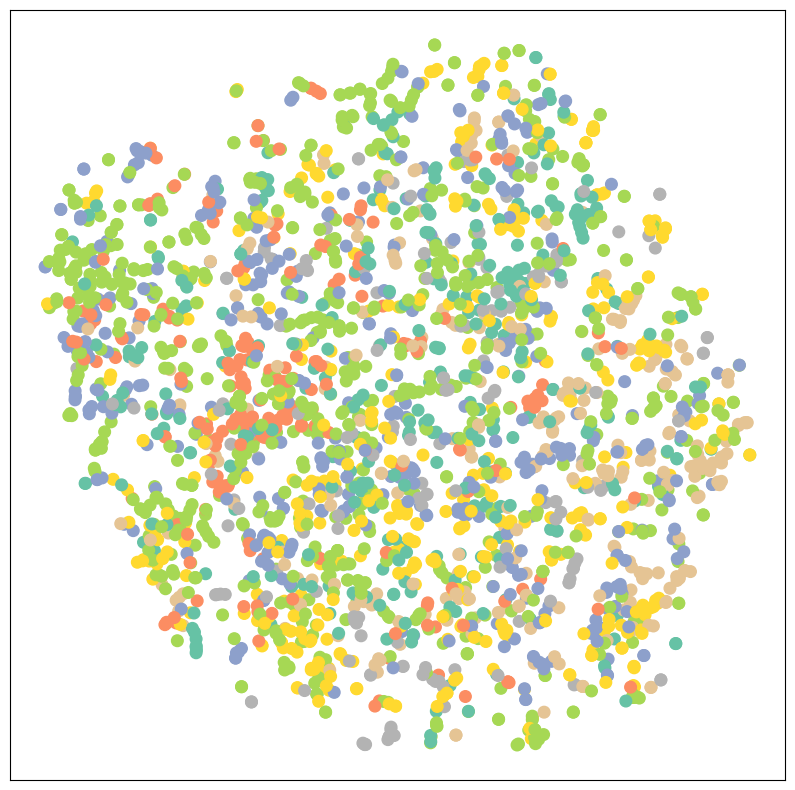

In [59]:
gcn.eval()
out = gcn(data.x, data.edge_index)
print(out.shape)
visualize(out, color=data.y)

In [63]:
model = GCN(in_feats, 16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
        return train_acc, test_acc


for e in range(101):
    loss = train()

    if e % 10 == 0:
        train_acc, test_acc = test()

        print(
            f"Epoch: {e:03d}, loss: {loss:.4f}, \
        train_acc: {train_acc:.3f}, test_acc: {test_acc:.3f}"
        )

Epoch: 000, loss: 1.9463,         train_acc: 0.371, test_acc: 0.270
Epoch: 010, loss: 1.8598,         train_acc: 0.721, test_acc: 0.468
Epoch: 020, loss: 1.7147,         train_acc: 0.893, test_acc: 0.657
Epoch: 030, loss: 1.5393,         train_acc: 0.943, test_acc: 0.728
Epoch: 040, loss: 1.3030,         train_acc: 0.971, test_acc: 0.781
Epoch: 050, loss: 1.0860,         train_acc: 0.957, test_acc: 0.793
Epoch: 060, loss: 0.9769,         train_acc: 0.964, test_acc: 0.803
Epoch: 070, loss: 0.8012,         train_acc: 0.964, test_acc: 0.808
Epoch: 080, loss: 0.6666,         train_acc: 0.971, test_acc: 0.807
Epoch: 090, loss: 0.6317,         train_acc: 0.979, test_acc: 0.814
Epoch: 100, loss: 0.5868,         train_acc: 0.986, test_acc: 0.814


In [64]:
out = model(data.x, data.edge_index)

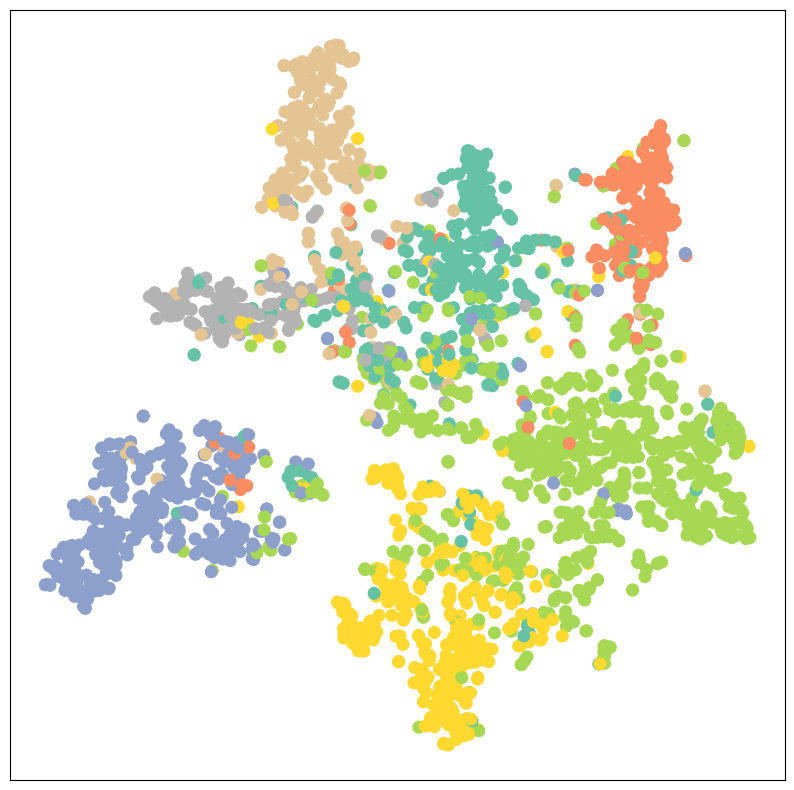

In [65]:
visualize(out, color=data.y)

## GAT
$$
    \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}_{s}\mathbf{x}_{i} +
    \sum_{j \in \mathcal{N}(i)}
    \alpha_{i,j}\mathbf{\Theta}_{t}\mathbf{x}_{j},
$$
where the attention coefficients :$\alpha_{i,j}$ are computed as

$$
    \alpha_{i,j} =
    \frac{
    \exp\left(\mathrm{LeakyReLU}\left(
    \mathbf{a}^{\top}_{s} \mathbf{\Theta}_{s}\mathbf{x}_i
    + \mathbf{a}^{\top}_{t} \mathbf{\Theta}_{t}\mathbf{x}_j
    \right)\right)}
    {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
    \exp\left(\mathrm{LeakyReLU}\left(
    \mathbf{a}^{\top}_{s} \mathbf{\Theta}_{s}\mathbf{x}_i
    + \mathbf{a}^{\top}_{t}\mathbf{\Theta}_{t}\mathbf{x}_k
    \right)\right)}.
$$
If the graph has multi-dimensional edge features :$\mathbf{e}_{i,j}$,
the attention coefficients $\alpha_{i,j}$ are computed as

$$
    \alpha_{i,j} =
    \frac{
    \exp\left(\mathrm{LeakyReLU}\left(
    \mathbf{a}^{\top}_{s} \mathbf{\Theta}_{s}\mathbf{x}_i
    + \mathbf{a}^{\top}_{t} \mathbf{\Theta}_{t}\mathbf{x}_j
    + \mathbf{a}^{\top}_{e} \mathbf{\Theta}_{e} \mathbf{e}_{i,j}
    \right)\right)}
    {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
    \exp\left(\mathrm{LeakyReLU}\left(
    \mathbf{a}^{\top}_{s} \mathbf{\Theta}_{s}\mathbf{x}_i
    + \mathbf{a}^{\top}_{t} \mathbf{\Theta}_{t}\mathbf{x}_k
    + \mathbf{a}^{\top}_{e} \mathbf{\Theta}_{e} \mathbf{e}_{i,k}
    \right)\right)}.
$$
If the graph is not bipartite, :$\mathbf{\Theta}_{s} =
\mathbf{\Theta}_{t}$.

```python
GATConv.forward(
    self,
    x: Union[torch.Tensor, Tuple[torch.Tensor, Union[torch.Tensor, NoneType]]],
    edge_index: Union[torch.Tensor, torch_sparse.tensor.SparseTensor],
    edge_attr: Union[torch.Tensor, NoneType] = None,
    size: Union[Tuple[int, int], NoneType] = None,
    return_attention_weights: Union[bool, NoneType] = None,
) -> Union[torch.Tensor, Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]], Tuple[torch.Tensor, torch_sparse.tensor.SparseTensor]]
```

In [76]:
from torch_geometric.nn import GATConv

in_feats = data.num_features
out_feats = dataset.num_classes


class GAT(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, heads):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_feats, hidden_feats, heads)
        self.conv2 = GATConv(hidden_feats * heads, hidden_feats, heads)
        self.conv3 = GATConv(hidden_feats * heads, hidden_feats, heads)
        self.conv4 = GATConv(hidden_feats * heads, hidden_feats, heads)
        self.conv5 = GATConv(hidden_feats * heads, hidden_feats, heads)
        self.conv6 = GATConv(hidden_feats * heads, out_feats, 1)

    def forward(self, x, edge_indx):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.conv1(h, edge_indx)
        h = h.relu()

        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_indx)
        h = h.relu()

        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv3(h, edge_indx)
        h = h.relu()

        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv4(h, edge_indx)
        h = h.relu()
        
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv5(h, edge_indx)
        h = h.relu()

        h = self.conv6(h, edge_indx)

        return h

In [77]:
model = GAT(in_feats, 16, out_feats, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        train_acc = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
        test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
        val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean()
        return train_acc, val_acc, test_acc


train_accs, val_accs, test_accs = [], [], []

for e in range(101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    if e % 10 == 0:
        print(
            f"Epoch: {e:03d}, loss: {loss:.4f}, \
        train_acc: {train_acc:.3f}, val_acc: {val_acc:.3f} ,test_acc: {test_acc:.3f}"
        )

Epoch: 000, loss: 1.9463,         train_acc: 0.143, val_acc: 0.058 ,test_acc: 0.064
Epoch: 010, loss: 1.6415,         train_acc: 0.400, val_acc: 0.454 ,test_acc: 0.450
Epoch: 020, loss: 1.1297,         train_acc: 0.400, val_acc: 0.274 ,test_acc: 0.269
Epoch: 030, loss: 0.8930,         train_acc: 0.686, val_acc: 0.502 ,test_acc: 0.519
Epoch: 040, loss: 0.7179,         train_acc: 0.857, val_acc: 0.702 ,test_acc: 0.710
Epoch: 050, loss: 0.4047,         train_acc: 0.950, val_acc: 0.720 ,test_acc: 0.746
Epoch: 060, loss: 0.2856,         train_acc: 0.971, val_acc: 0.684 ,test_acc: 0.700
Epoch: 070, loss: 0.3235,         train_acc: 0.993, val_acc: 0.698 ,test_acc: 0.721
Epoch: 080, loss: 0.2780,         train_acc: 0.979, val_acc: 0.722 ,test_acc: 0.748
Epoch: 090, loss: 0.2677,         train_acc: 0.993, val_acc: 0.692 ,test_acc: 0.728
Epoch: 100, loss: 0.1793,         train_acc: 0.993, val_acc: 0.686 ,test_acc: 0.723


### 两层GAT

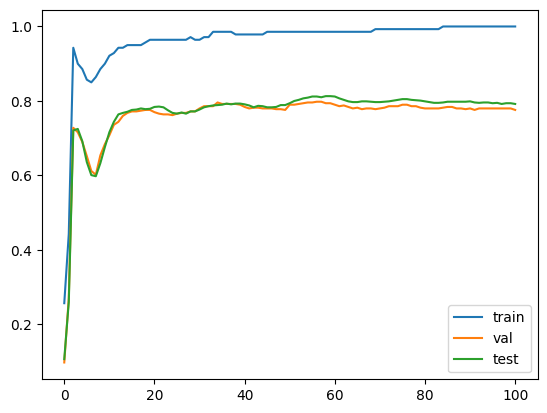

In [64]:
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.plot(test_accs, label="test")
plt.legend()
plt.show()

### 四层GAT


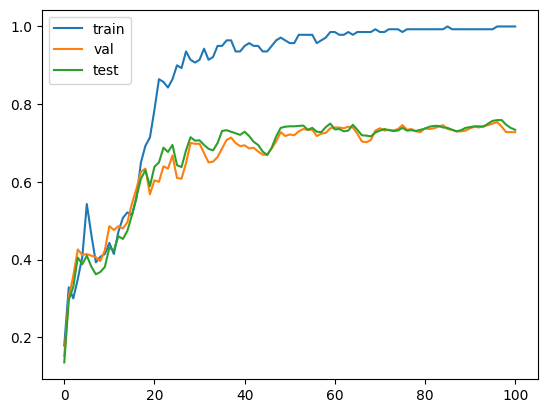

In [75]:
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.plot(test_accs, label="test")
plt.legend()
plt.show()

### 四层GAT

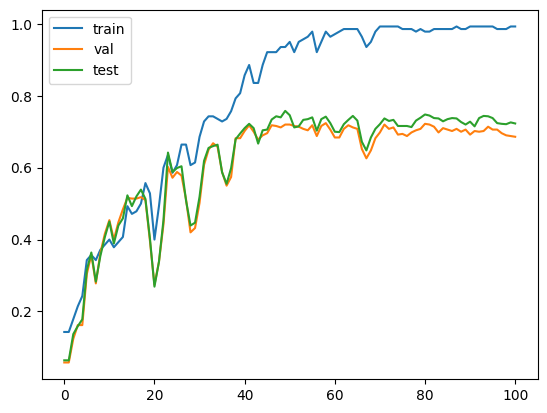

In [78]:
plt.plot(train_accs, label="train")
plt.plot(val_accs, label="val")
plt.plot(test_accs, label="test")
plt.legend()
plt.show()

layer过多可能产生over-smoothing